In [2]:
import numpy as np
# import scipy
from scipy.ndimage import gaussian_filter1d as g_filter
# from astropy import units as u
import matplotlib.pyplot as plt
# import pandas as pd
from tools.file_finder import find_file

In [14]:
date = "210513"
date2 = "210611"
date3 = "210610"
date4 = "210621"
date5 = "210625"
date6 = "210810"
date7 = "210831"
date8 = "210903"
date9 = "210907"

odmr_paths = [

    find_file("ODMR", 1, date7, contains="Counts"),
    find_file("ODMR", 2, date7, contains="Counts"),
    find_file("ODMR", 8, date7, contains="Counts"),
    find_file("ODMR", 12, date7, contains="Counts"),
    find_file("ODMR", 15, date7, contains="Counts"),
    find_file("ODMR", 18, date7, contains="Counts"),
    find_file("ODMR", 22, date8, contains="Counts"), # Long calibration one, no oscillation
    find_file("ODMR", 23, date8, contains="Counts"),
    find_file("ODMR", 11, date7, contains="Counts"),
    # find_file("ODMR", 2, date9, contains="Counts"),
]
odmr_specs = [
    np.genfromtxt(f) for f in odmr_paths
]

num_not_final = len(odmr_specs)
swp_spcs = slice(0, num_not_final) # Later we will want to only fetch specs from this original list

freq_axes = [spec[0] for spec in odmr_specs]
odmr_specs = [spec[1:] for spec in odmr_specs]

final_paths = []
    # "ODMR_3_2peaks.txt", #"ODMR_4_same_as_3.txt"
# ]
final_specs = [
    np.genfromtxt(f, skip_header=18).T for f in final_paths
]
freq_axes += [spec[0] for spec in final_specs]
odmr_specs += [spec[1].reshape(1,-1) for spec in final_specs]
odmr_paths += final_paths
odmr_paths  = [path[-30:] for path in odmr_paths]
# odmr_specs[-2].shape

## Plot Counts for each:

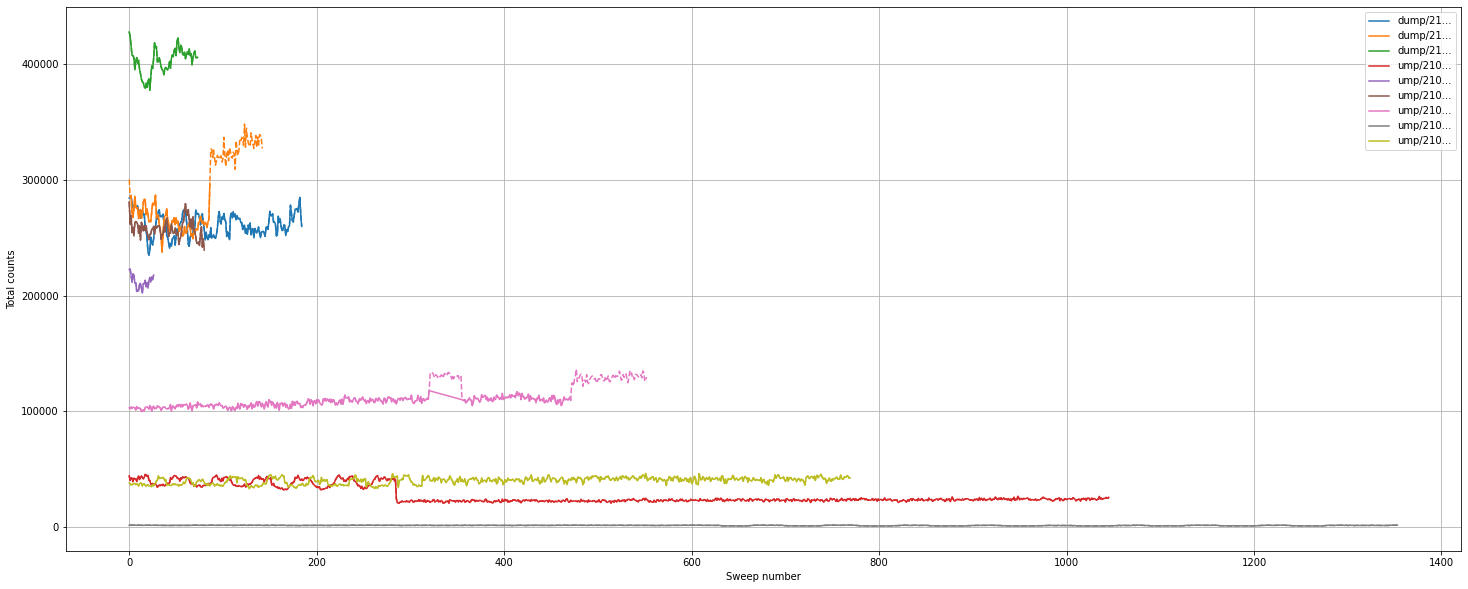

In [15]:
plt.figure(figsize=(25, 10))

range_selections = [slice(None, None, None) for _ in odmr_specs]
range_selections[1] = odmr_specs[1].sum(axis=1) < 300000
range_selections[6] = odmr_specs[6].sum(axis=1) < 120000
# range_selections[1] = slice(0, 70)
# range_selections[3] = odmr_specs[3].sum(axis=1) > 1.5e6
# range_selections[2] = slice(150, None, None)
# range_selections[2] = slice(None, 70)
# range_selections[4 - 3] = slice(None, 75)
# range_selections[5 - 3] = slice(0, 100)
# range_selections[6 - 3] = slice(0, 180)
# range_selections[5] = slice(120, None, None)
# range_selections[9] = slice(None, 400)
for spec, lbl, rng in zip(odmr_specs[swp_spcs], odmr_paths[swp_spcs], range_selections):
    sweep_counts = spec.sum(axis=1)
    sweep_ax = np.arange(len(sweep_counts))
    f, = plt.plot(sweep_counts, '--')
    plt.plot(sweep_ax[rng], sweep_counts[rng], f.get_color(), label=lbl[:7]+'...')

plt.legend()
plt.grid()
plt.xlabel("Sweep number")
plt.ylabel("Total counts")
# plt.xlim(200, 600)
plt.show()


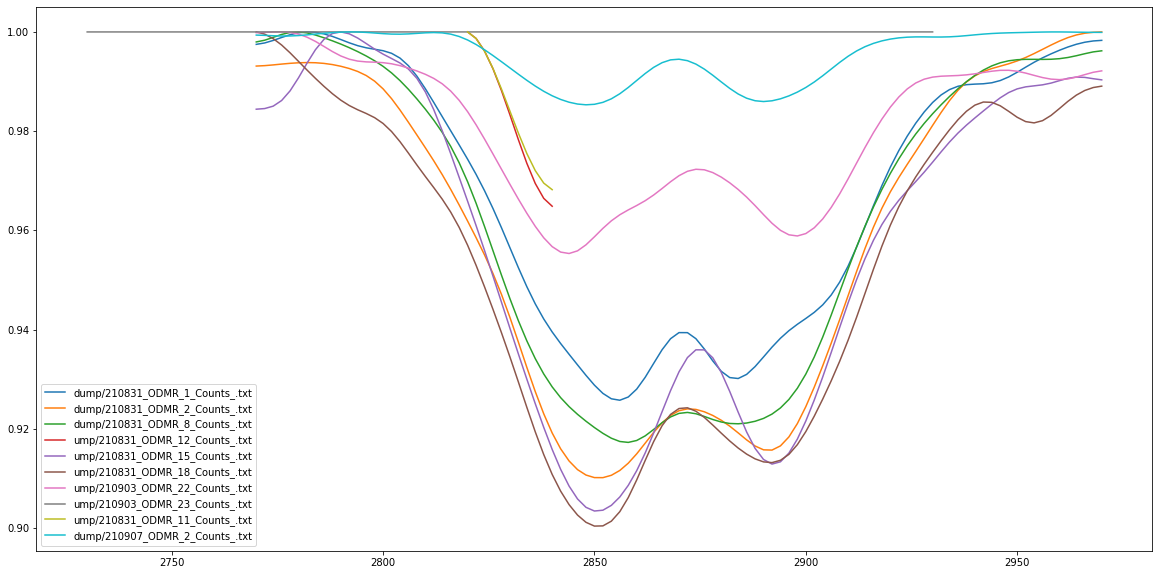

In [5]:
plt.figure(figsize=(20, 10))

full_specs = []

for freq, spec, selection in zip(freq_axes, odmr_specs, range_selections):
    full_spec = spec[selection].sum(axis=0)
    # smooth
    full_spec = g_filter(full_spec, 3)
    # full_spec /= spec[selection].shape[1]
    full_spec /= max(full_spec)
    full_specs.append(full_spec)
    plt.plot(freq, full_spec)
plt.legend(odmr_paths)
plt.show()

good_specs = [0, 1, 2, 4, 5,6, 9]
full_good_specs = [full_specs[i] for i in good_specs]
good_freqs = [freq_axes[i] for i in good_specs]

Estimated B-field: 0.50 mT, freqs: [2856. 2884.]
Estimated B-field: 0.71 mT, freqs: [2852. 2892.]
Estimated B-field: 0.46 mT, freqs: [2858. 2884.]
Estimated B-field: 0.75 mT, freqs: [2850. 2892.]
Estimated B-field: 0.75 mT, freqs: [2850. 2892.]
Estimated B-field: 0.96 mT, freqs: [2844. 2898.]
Estimated B-field: 0.75 mT, freqs: [2848. 2890.]


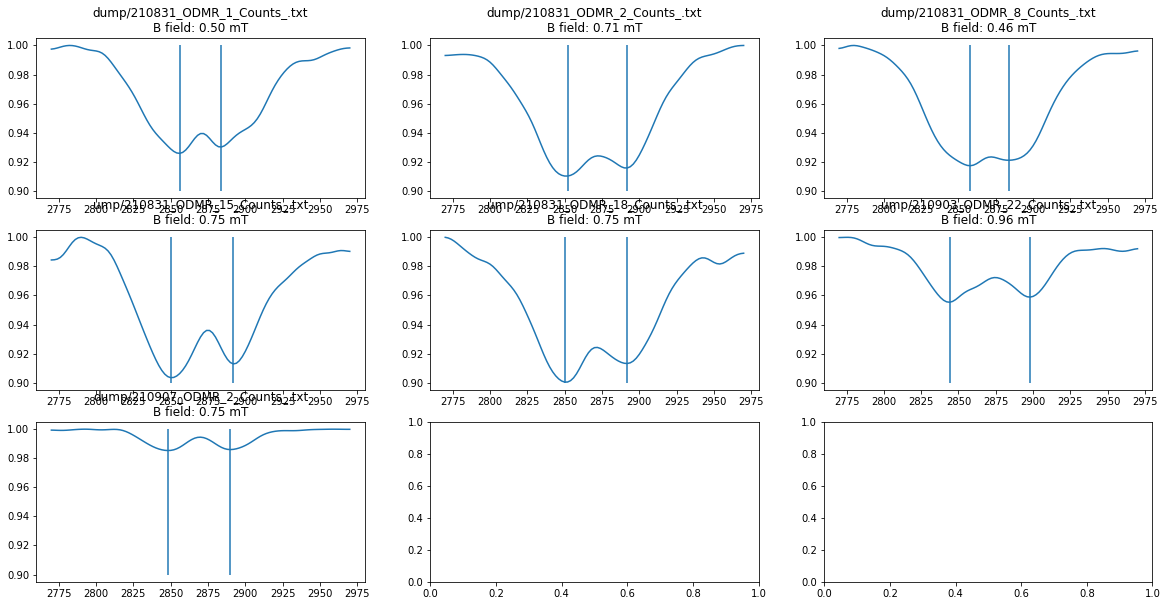

In [6]:
def find_peaks_sp(data, num_peaks):
    """ Find a specific number of peaks by finding the stationary points with the
    highest values in data. """
    diff = np.diff(data)
    # Find which values cross over zero
    prod = diff[1:] * diff[:-1]
    # prod will be negative where diff has crossed the x-axis
    sps = np.flatnonzero(prod < 0) + 1

    values = data[sps]
    pks = sps[values.argsort()[:num_peaks]]

    return pks

n_cols = 3

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(
    nrows=(n_cols - 1 + len(good_freqs)) // n_cols, 
    ncols=n_cols, sharex="none").flatten()
for freq, s, ax, i in zip(good_freqs, full_good_specs, axes, good_specs):
    pks = find_peaks_sp(s, 2)
    ax.plot(freq, s)
    freq_pks = freq[pks]
    ax.vlines(freq_pks, ymin=0.9, ymax=1)
    freq_sep = abs(np.diff(freq_pks))
    b_field = freq_sep[0] / 56
    ax.set_title(f"{odmr_paths[i]}\nB field: {b_field:.2f} mT")
    print(f"Estimated B-field: {b_field:.2f} mT, freqs: {freq_pks}")

plt.show()

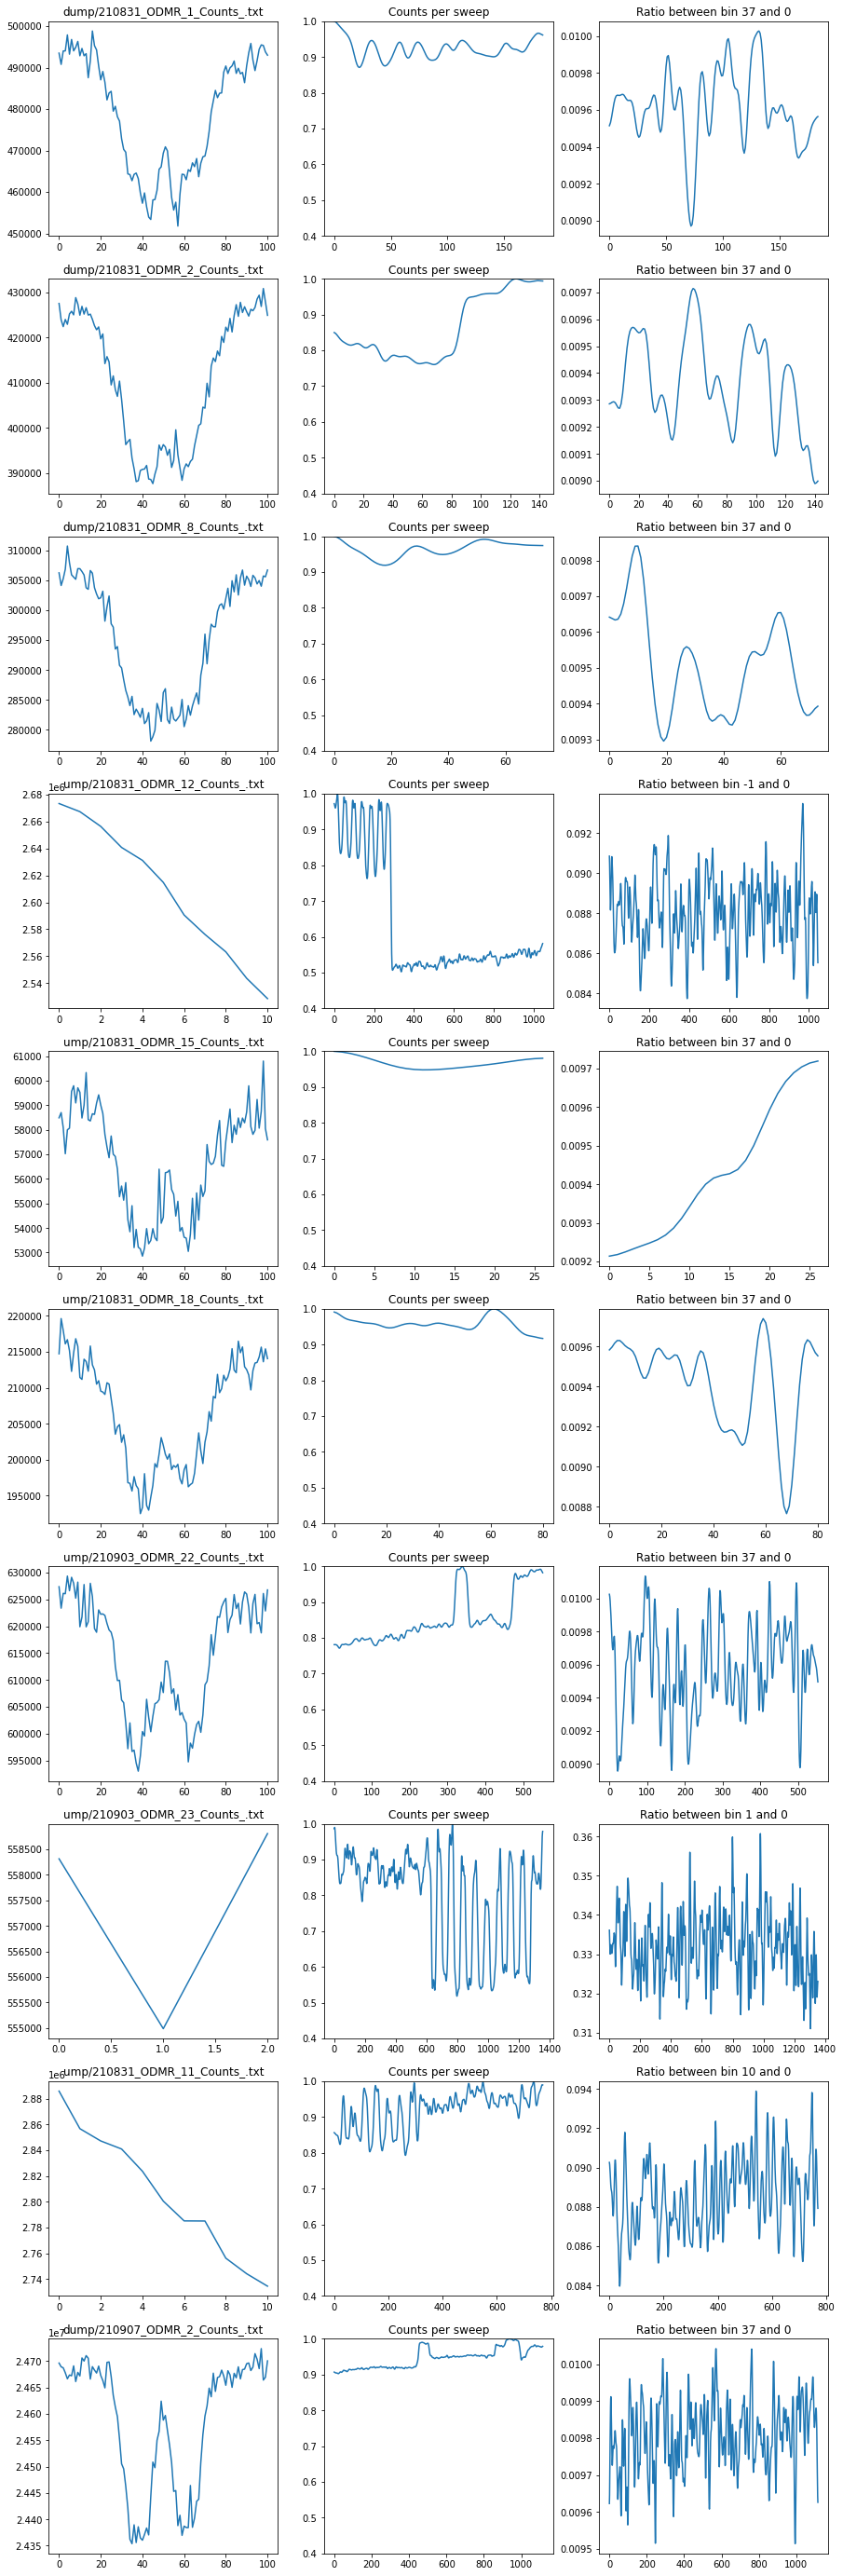

In [9]:
n_specs = len(odmr_specs)
n_rows = n_specs
fig = plt.figure(figsize=(15, n_rows*5))
axes = fig.subplots(nrows=n_rows, ncols=3)
edges = [37] * n_specs
edges[3] = -1
edges[7] = 1
edges[8] = 10
for i, (spec, title, axis_row, x) in enumerate(zip(odmr_specs, odmr_paths, axes, edges)):
    left_ax, right_ax, third_ax = axis_row
    left_ax.set_title(title)
    right_ax.set_title("Counts per sweep")
    third_ax.set_title("Ratio between bin %d and 0" % x)
    counts = g_filter(spec.sum(axis=1), 3)
    left_ax.plot(spec.sum(axis=0))
    right_ax.plot(counts / max(counts))
    right_ax.set_ylim(0.4, 1)
    edge_counts = g_filter(spec[:, x], 3)
    edge_ref = g_filter(spec[:, 0], 3)
    try:
        third_ax.plot(edge_counts / counts)
    except:
        pass
plt.show()

In [11]:
thisone = odmr_specs[7]


(1354, 3)